## Anomaly detector
With all the knowledge gained in the other notebooks I will make an anomaly detector who will correctly recognized leaks. This will be made with Polinomal regression and rolling mean.

### Data loading and data preperation

In [1]:
import math
import pandas as pandas
from pandas import concat
import numpy as np
from scipy.stats import pearsonr
from statistics import mean
from numpy.random import shuffle

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

data = pandas.read_json("../data/water_loss_data_set_1.json")

Removing missing values and making a copy of the original data set. Formating timeStamp column into a string.

In [2]:
data = data[(data.timeStamp != "0000-00-00 00:00:00" ) & (data.timeStamp != "2000-01-01 00:00:00")]

data = data[(data.tot1 != 0 ) & (data.analog2 != 0)]
data["timeStamp"] = pandas.to_datetime(data["timeStamp"], format="%Y-%m-%d %H:%M")

# COMMENT THIS IF YOU WANT MORE SPEED
data_with_minutes = data.copy(deep=True)

Making a data set with 15 min average and tabelarised date.

In [3]:
data_249_15 = data_with_minutes[data_with_minutes['idflowmeter'] == "MAG8000_024905H318"]
data_248_15 = data_with_minutes[data_with_minutes['idflowmeter'] == "MAG8000_024805H318"]

data_249_15_avg = data_249_15.resample(rule='60Min', on='timeStamp').mean()
data_248_15_avg = data_248_15.resample(rule='60Min', on='timeStamp').mean()

data_248_15_avg['day'] = [i.day for i in data_248_15_avg.index]
data_248_15_avg['month'] = [i.month for i in data_248_15_avg.index]
data_248_15_avg['year'] = [i.year for i in data_248_15_avg.index]
data_248_15_avg['hour'] = [i.hour for i in data_248_15_avg.index]
data_248_15_avg['minute'] = [i.minute for i in data_248_15_avg.index]

data_249_15_avg['day'] = [i.day for i in data_249_15_avg.index]
data_249_15_avg['month'] = [i.month for i in data_249_15_avg.index]
data_249_15_avg['year'] = [i.year for i in data_249_15_avg.index]
data_249_15_avg['hour'] = [i.hour for i in data_249_15_avg.index]
data_249_15_avg['minute'] = [i.minute for i in data_249_15_avg.index]

# for handling nan values 
"""
print(data_248_15_avg.isna().any())
data_248_15_avg["analog2"].fillna(data_248_15_avg["analog2"].mean(), inplace=True)
data_248_15_avg["tot1"].fillna(data_248_15_avg["tot1"].mean(), inplace=True)
data_248_15_avg["tot2"].fillna(data_248_15_avg["tot2"].mean(), inplace=True)
"""

data_248_15_avg

,tot1,tot2,analog2,day,month,year,hour,minute
timeStamp,,,,,,,,
2018-12-11 12:00:00,161.873400,0.00,0.819200,11,12,2018,12,0
2018-12-11 13:00:00,264.282667,0.00,0.820333,11,12,2018,13,0
2018-12-11 14:00:00,371.478000,0.00,0.818333,11,12,2018,14,0
2018-12-11 15:00:00,487.519333,0.00,0.813167,11,12,2018,15,0
2018-12-11 16:00:00,601.331833,0.00,0.810833,11,12,2018,16,0
...,...,...,...,...,...,...,...,...
2020-04-01 10:00:00,977299.898333,-4713.21,1.527333,1,4,2020,10,0
2020-04-01 11:00:00,977333.727167,-4713.21,1.528500,1,4,2020,11,0
2020-04-01 12:00:00,977369.184833,-4713.21,1.530500,1,4,2020,12,0


Making a dataset with data averaged on an hourly basis.

In [4]:
# flooring to the nearest hour and grouping by hour, and removing seconds and minutes
data["timeStamp"] = data["timeStamp"].dt.floor('h')
data["timeStamp"] = data["timeStamp"].dt.strftime("%Y-%m-%d %H:%M")
data["timeStamp"] = pandas.to_datetime(data["timeStamp"], format="%Y-%m-%d %H:%M")

Splitting the data by measuring station.

In [5]:
data_249 = data[data['idflowmeter'] == "MAG8000_024905H318"]
data_248 = data[data['idflowmeter'] == "MAG8000_024805H318"]

data_249.sort_values("timeStamp")
data_248.sort_values("timeStamp")
data_249_by_hour = data_249.groupby("timeStamp").mean()
data_248_by_hour = data_248.groupby("timeStamp").mean()

data_249_by_hour['day'] = [i.day for i in data_249_by_hour.index]
data_249_by_hour['month'] = [i.month for i in data_249_by_hour.index]
data_249_by_hour['year'] = [i.year for i in data_249_by_hour.index]
data_249_by_hour['hour'] = [i.hour for i in data_249_by_hour.index]
data_249_by_hour['minute'] = [i.minute for i in data_249_by_hour.index]

data_248_by_hour['day'] = [i.day for i in data_248_by_hour.index]
data_248_by_hour['month'] = [i.month for i in data_248_by_hour.index]
data_248_by_hour['year'] = [i.year for i in data_248_by_hour.index]
data_248_by_hour['hour'] = [i.hour for i in data_248_by_hour.index]
data_248_by_hour['minute'] = [i.minute for i in data_248_by_hour.index]

data_249_by_hour.index = data_249_by_hour.index.strftime("%Y-%m-%d %H:%M")
data_248_by_hour.index = data_248_by_hour.index.strftime("%Y-%m-%d %H:%M")

data_249_by_hour

,tot1,tot2,analog2,day,month,year,hour,minute
timeStamp,,,,,,,,
2018-11-23 08:00,1.410000,0.00,1.110000,23,11,2018,8,0
2018-11-23 09:00,30.987273,0.00,1.103409,23,11,2018,9,0
2018-11-23 10:00,87.809457,0.00,1.099022,23,11,2018,10,0
2018-11-23 11:00,182.008000,0.00,1.101000,23,11,2018,11,0
2018-11-23 12:00,278.252500,0.00,0.960333,23,11,2018,12,0
...,...,...,...,...,...,...,...,...
2020-04-01 04:00,796739.947500,-293.97,0.826000,1,4,2020,4,0
2020-04-01 05:00,796816.443333,-293.97,0.824667,1,4,2020,5,0
2020-04-01 06:00,796915.016000,-293.97,0.817167,1,4,2020,6,0


**Functions for further use.**

In [16]:
def data_sel(start, end, data_fun):
    return data_fun.loc[(data_fun.index >= start) & (data_fun.index <= end)]   

def add_rolling_column(data, width):
    data["analog2"].fillna(data["analog2"].mean(), inplace=True)
    data["tot1"].fillna(data["tot1"].mean(), inplace=True)
    data["tot2"].fillna(data["tot2"].mean(), inplace=True)
    
    temp = pandas.DataFrame(data["analog2"])
    temp.columns = ["rolling-analog"]

    temp = temp.rolling(window=width).mean()
    
    dataframe = concat([data, temp], axis=1)
    dataframe = dataframe.drop(dataframe.index[[i for i in range(0, width - 1)]])
    
    dataframe = dataframe.reindex(["tot1", "tot2", "analog2", 
                                        "rolling-analog", "hour", "minute", "day", "month", "year",],axis=1)
    # print(dataframe.head(10))
    return dataframe

def split_learn_test(data):
    data_matrix = data.values
    
    learn_len = round(len(data_matrix) * 0.7)
    # removing tot1 and tot2 from matrix
    learn_set = data_matrix[:learn_len, 2:]
    test_set = data_matrix[learn_len:, 2:]
    
    return learn_set, test_set


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def poli_regression(learn, test):
    X_train = learn[:, 2:4]
    X_test = test[:, 2:4]
    
    y_train = learn[:, 0:1]
    y_test = test[:, 0:1]
    
    """      
    x_ = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X_train)
    x_test = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X_test)

    model = LinearRegression(fit_intercept=False).fit(x_, y_train)
    y_pred = model.predict(x_test)
    
    model = Ridge().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    diff = mean_squared_error(y_test, y_pred_rf)
    print("MSE result:", diff)
    
    coefficient_of_dermination = r2_score(y_test, y_pred)
    print("R2 score: ", coefficient_of_dermination)
    """
    # RANDOM FOREST
    # Instantiate model with 1000 decision trees
    regressor_rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    regressor_rf.fit(X_train, y_train.ravel())
    y_pred_rf = regressor_rf.predict(X_test)
    
    r2_random_f = r2_score(y_test, y_pred_rf)
    print("Random forest regression R2: ", r2_random_f)
       
    print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred_rf))
    
    draw_target_value(y_pred_rf, y_test)

def draw_target_value(y_pred, y_test):
    plt.figure(figsize=(25, 15), dpi= 100)
    plt.plot([i for i in range(len(y_test))], y_test, color='red', label="Actual data")
    plt.plot([i for i in range(len(y_pred))], y_pred, color='blue', label="Predicted")
    plt.title('Example polinomial regression')
    plt.legend()
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

def normalize_data(data):
    data = ((data - data.min()) / (data.max() - data.min()))
    return data

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Random forest regression R2:  0.047871548980845446
MAPE:  3.0164149453733478


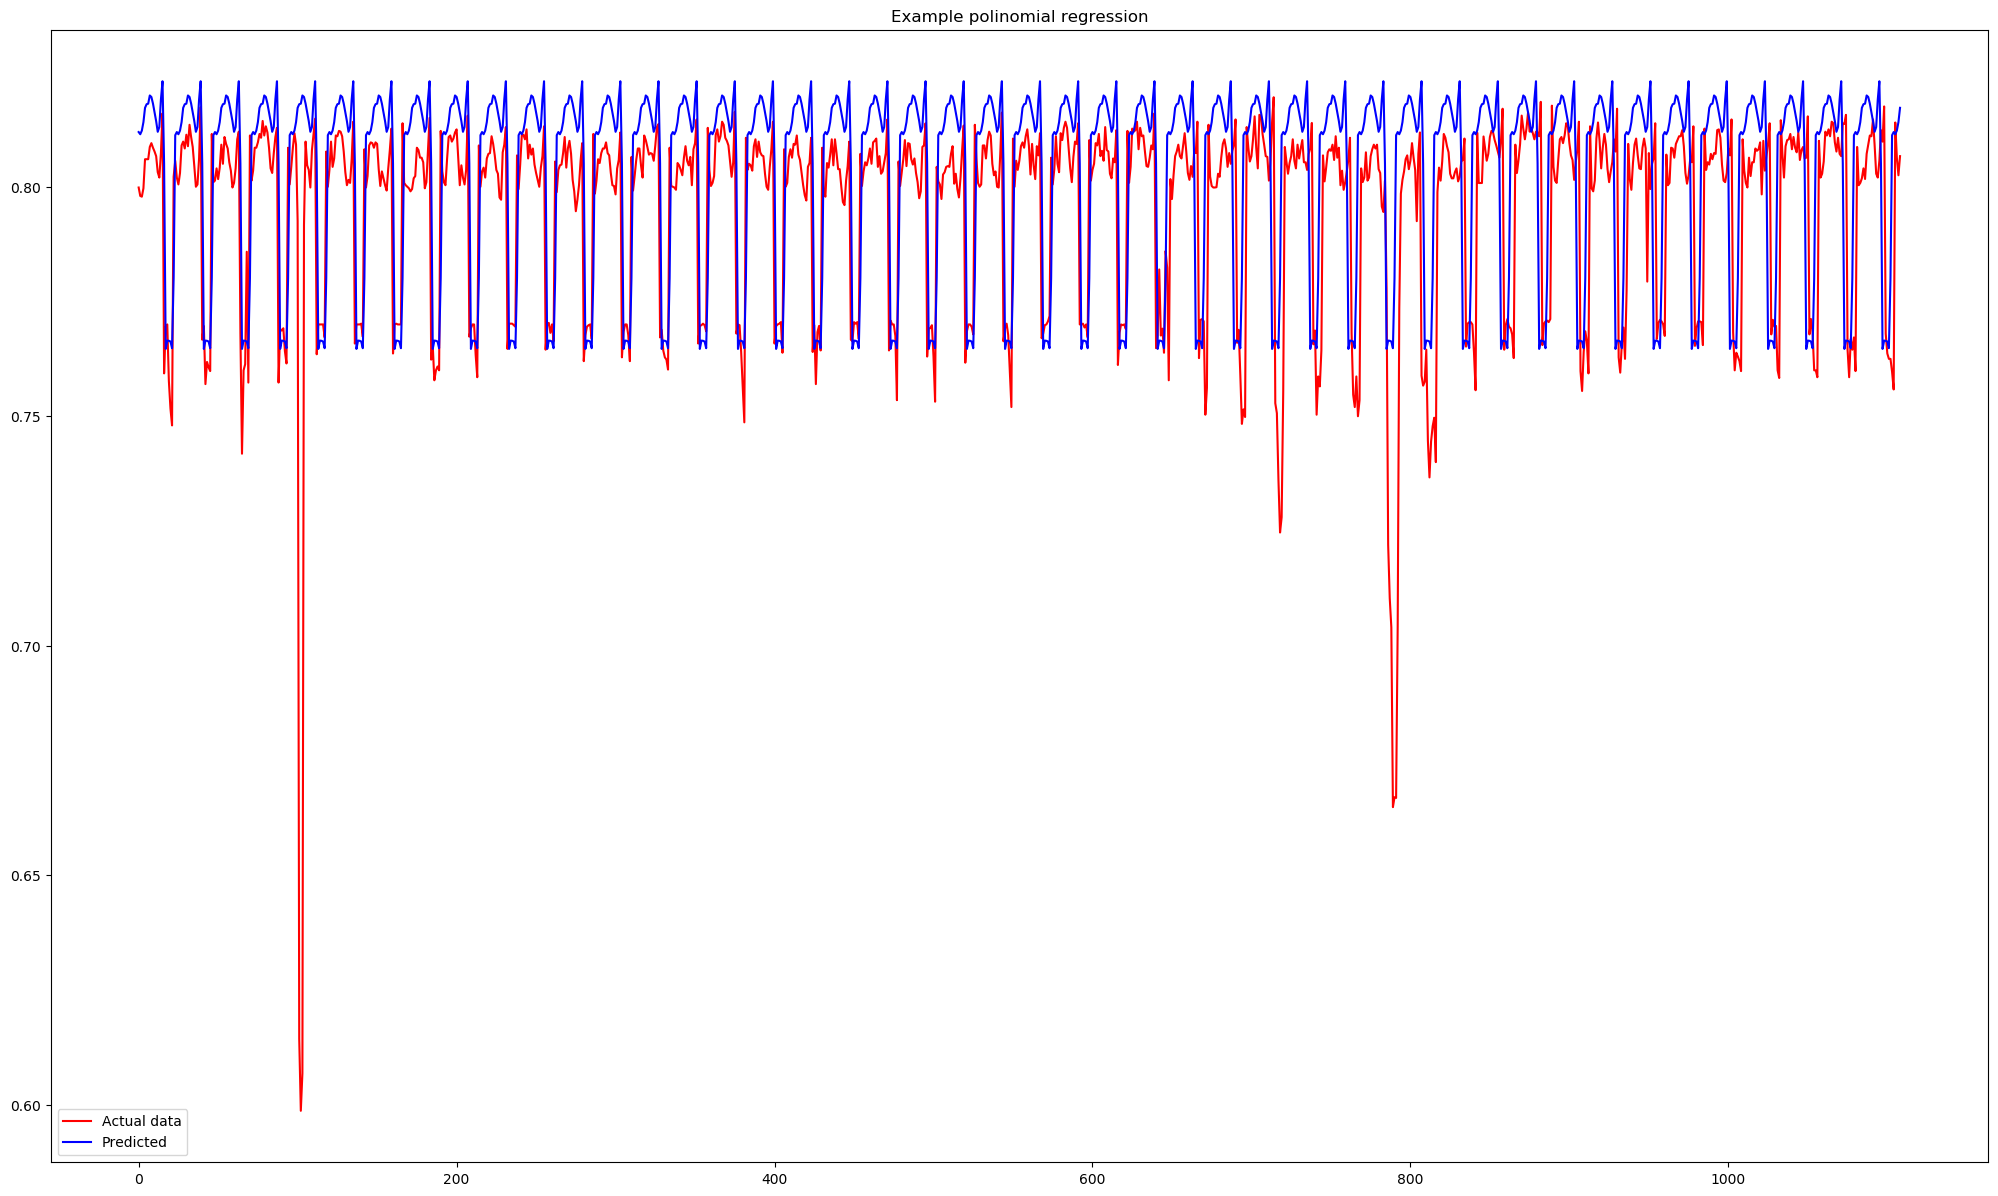

,tot1,tot2,analog2,rolling-analog,hour,minute,day,month,year
timeStamp,,,,,,,,,
2019-01-23 10:00:00,82077.629667,-23.0600,0.824500,0.826167,10,0,23,1,2019
2019-01-23 11:00:00,82150.499333,-23.0600,0.829667,0.827667,11,0,23,1,2019
2019-01-23 12:00:00,82222.397500,-23.0600,0.831000,0.828389,12,0,23,1,2019
2019-01-23 13:00:00,82298.088333,-23.0600,0.829333,0.830000,13,0,23,1,2019
2019-01-23 14:00:00,82373.806333,-23.0600,0.827167,0.829167,14,0,23,1,2019
...,...,...,...,...,...,...,...,...,...
2019-06-26 04:00:00,274986.720167,-278.8435,0.755833,0.759333,4,0,26,6,2019
2019-06-26 05:00:00,274996.198667,-279.9600,0.814000,0.776500,5,0,26,6,2019
2019-06-26 06:00:00,275026.838833,-279.9600,0.806333,0.792056,6,0,26,6,2019


In [17]:
def main_function(data, window_width):
    work_data = data_sel("2019-01-23 08:00:00", "2019-06-26 08:00:00", data)
    rolling_data = add_rolling_column(work_data, window_width)
    # rolling_data = normalize_data(rolling_data)
    
    learn, test = split_learn_test(rolling_data)
    # print(learn[:3, 1:], test[:3, 1:], learn[:3, 0:1], test[:3, 0:1])
    poli_regression(learn, test)

    return rolling_data

main_function(data_249_15_avg, 3)

In [8]:
"""print(data_248_15_avg.isna().any())

with pandas.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data_248_15_avg[data_248_15_avg.isna().any(axis=1)])""";